import pandas as pd
import xgboost as xgb
import numpy as np
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, accuracy_score, recall_score

## Step 1: Read the input data and load it into a Pandas DataFrame

In [3]:
data_url = "gs://cloud-samples-data/ai-platform-unified/datasets/tabular/petfinder-tabular-classification.csv"
df = pd.read_csv(data_url)
df

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,Yes
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,Yes
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,Yes
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,Yes
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,Healthy,0,0,No
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,Healthy,0,1,Yes
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,Healthy,0,1,Yes
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,Healthy,0,3,No


## Exploratory data analysis (EDA)

In [4]:
print(df.head())
print("*****************************************************************************************")
# Get summary statistics of numerical columns
print(df.describe())
print("*****************************************************************************************")
# Check the data types of columns
print(df.dtypes)
print("*****************************************************************************************")
# Check the dimensions of the DataFrame
print(df.shape)
print("*****************************************************************************************")
print(df.info)


  Type  Age                Breed1  Gender Color1    Color2 MaturitySize  \
0  Cat    3                 Tabby    Male  Black     White        Small   
1  Cat    1  Domestic Medium Hair    Male  Black     Brown       Medium   
2  Dog    1           Mixed Breed    Male  Brown     White       Medium   
3  Dog    4           Mixed Breed  Female  Black     Brown       Medium   
4  Dog    1           Mixed Breed    Male  Black  No Color       Medium   

  FurLength Vaccinated Sterilized   Health  Fee  PhotoAmt Adopted  
0     Short         No         No  Healthy  100         1     Yes  
1    Medium   Not Sure   Not Sure  Healthy    0         2     Yes  
2    Medium        Yes         No  Healthy    0         7     Yes  
3     Short        Yes         No  Healthy  150         8     Yes  
4     Short         No         No  Healthy    0         3     Yes  
*****************************************************************************************
                Age           Fee      PhotoAmt
cou

Looking at the data, I need to preform some pre-processing:
*   Encoding the bread, gender, color1, color2, maturaty size, FurLength, Vaccinated, Sterilized,   Health.
*   Remove the outliers then normalise the Age, PhotoAmt.
*   Handling missing data like (not sure for vacinated, sterilized)
Color2: is dropped because it is mostly empty and given the fact there is already color1 I just dropped it.








               Age       Fee  PhotoAmt
Age       1.000000  0.086637 -0.063674
Fee       0.086637  1.000000  0.019387
PhotoAmt -0.063674  0.019387  1.000000


<AxesSubplot:>

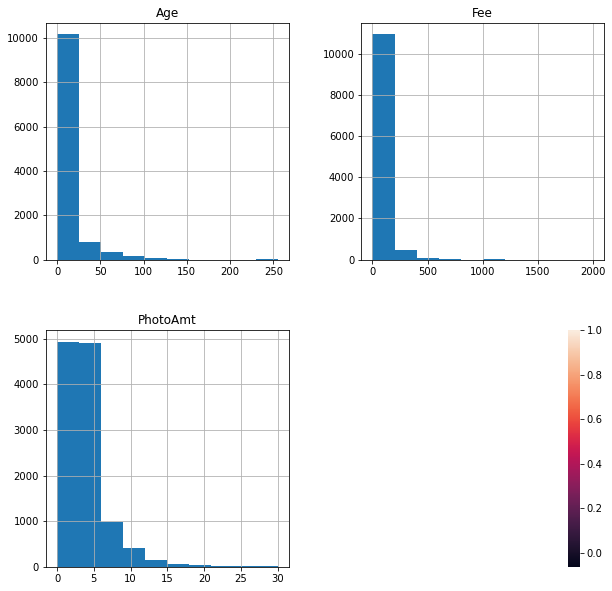

In [5]:
# Generate histograms for numerical columns
df.hist(figsize=(10, 10))

# Create box plots to visualize distributions and detect outliers
df.boxplot(figsize=(10, 6))

# Calculate correlations between columns
correlation_matrix = df.corr()
print(correlation_matrix)

# Visualize correlations using a heatmap
import seaborn as sns
sns.heatmap(correlation_matrix, annot=True)


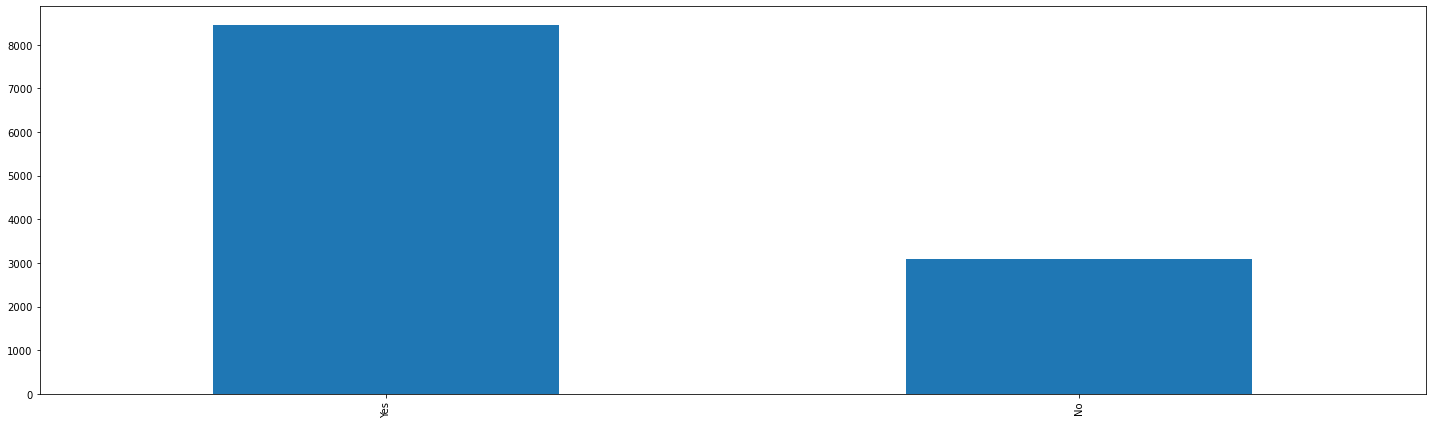

In [6]:
# Count the occurrences of each category in a categorical column
# Obviously imbalanced dataset this will be handled with SMOTE
breed_counts = df['Adopted'].value_counts()

# Create a bar plot with rotated x-axis labels
plt.figure(figsize=(20, 6))  # Adjust the figure size as needed
ax = breed_counts.plot(kind='bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Rotate x-axis labels
plt.tight_layout()  # To prevent label cutoffs
plt.show()



In [7]:
skewness = df['PhotoAmt'].skew()
print("Skewness:", skewness)


Skewness: 2.894013721756597


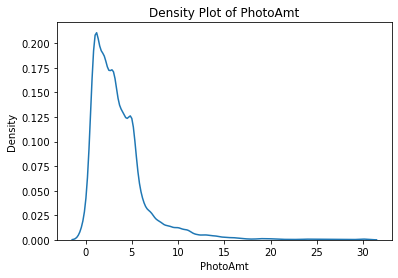

In [8]:
import seaborn as sns

sns.kdeplot(df['PhotoAmt'])
plt.xlabel('PhotoAmt')
plt.ylabel('Density')
plt.title('Density Plot of PhotoAmt')
plt.show()


In [9]:
df

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,Yes
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,Yes
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,Yes
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,Yes
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,Healthy,0,0,No
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,Healthy,0,1,Yes
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,Healthy,0,1,Yes
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,Healthy,0,3,No


## Step 2: Split the dataset into 3 splits: train, validation and test with ratios of 60 (train) / 20 (validation) / 20 (test)

In [10]:
from data_processing import preprocess_csv

#preprocess_csv is a custom function that can be found in the data_processing.py file
features, target, encoded_df = preprocess_csv(df)
X_train, X_test, y_train, y_test = train_test_split(encoded_df[features], target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

10.60718789407314 17.79262540329333
3.7696289905090596 3.3005530611492055


/Users/shahdghorsi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/shahdghorsi/Desktop/virgin_media/data_processing.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame["Adopted"] = label_encoder.fit_transform(data_frame["Adopted"])


In [11]:
# Perform SMOTE resampling on the training set only
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


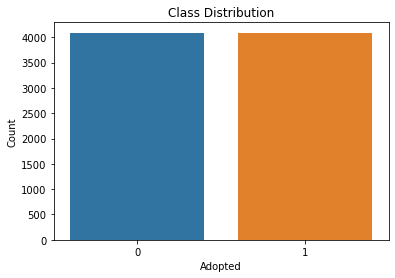

In [12]:
# Create a countplot to visualize the class distribution
sns.countplot(x=y_train_resampled)
plt.xlabel("Adopted")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()


## 4. Train an ML model using XGBoost  model with early stopping using the resampled training set

In [13]:
dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dval = xgb.DMatrix(X_val, label=y_val)


params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "eta": 0.3,
    "max_depth": 7
}

model = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=10, evals=[(dval, "validation")])



[0]	validation-logloss:0.62472
[1]	validation-logloss:0.58947
[2]	validation-logloss:0.56807
[3]	validation-logloss:0.55363
[4]	validation-logloss:0.53987
[5]	validation-logloss:0.53141
[6]	validation-logloss:0.52866
[7]	validation-logloss:0.52623
[8]	validation-logloss:0.51835
[9]	validation-logloss:0.51554
[10]	validation-logloss:0.51365
[11]	validation-logloss:0.51163
[12]	validation-logloss:0.51071
[13]	validation-logloss:0.50851
[14]	validation-logloss:0.50741
[15]	validation-logloss:0.50238
[16]	validation-logloss:0.50194
[17]	validation-logloss:0.50169
[18]	validation-logloss:0.50261
[19]	validation-logloss:0.50046
[20]	validation-logloss:0.49962
[21]	validation-logloss:0.49849
[22]	validation-logloss:0.49851
[23]	validation-logloss:0.49843
[24]	validation-logloss:0.49715
[25]	validation-logloss:0.49714
[26]	validation-logloss:0.49857
[27]	validation-logloss:0.49821
[28]	validation-logloss:0.49774
[29]	validation-logloss:0.49806
[30]	validation-logloss:0.49798
[31]	validation-lo

In [14]:
# Evaluate the model on the test set
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)


In [15]:
# Logging the performance metrics
print("F1 Score:", f1)
print("Accuracy:", accuracy)
print("Recall:", recall)

F1 Score: 0.8348391760028911
Accuracy: 0.7486248624862486
Recall: 0.8486407053637032


SMOTE:
* F1 Score: 0.8310249307479225
* Accuracy: 0.7436974789915967
* Recall: 0.847457627118644

Downsampling:
* F1 Score: 0.7745173745173746
* Accuracy: 0.6932773109243697
* Recall: 0.7083333333333334

Normalised age:
* F1 Score: 0.8345575376005596
* Accuracy: 0.7515756302521008
* Recall: 0.8425141242937854

Normalised Age and PhotoAmt:
* F1 Score: 0.8386873920552678
* Accuracy: 0.7547268907563025
* Recall: 0.8573446327683616

Dropped Fee:
* F1 Score: 0.834257975034674
* Accuracy: 0.7489495798319328
* Recall: 0.8495762711864406

Normalised Fee:
* F1 Score: 0.8326983027364047
* Accuracy: 0.7463235294117647
* Recall: 0.8488700564971752

Removed age outliers and normalized:
* F1 Score: 0.8434752022511431
* Accuracy: 0.7601078167115903
* Recall: 0.8594982078853046

Removed photAmt outliers and normalized
* F1 Score: 0.8458806818181819
* Accuracy: 0.7612761276127613
* Recall: 0.8750918442321822






In [18]:
# Save the model
model.save_model("artifacts/model.xgb")
